<a href="https://colab.research.google.com/github/Javcm/Intro-a-Deep-Learning-UNAM-FC/blob/main/object_detection_yoloV3_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Pretrained Model

In [1]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims

In [5]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)

            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance

                    weights = norm_layer.set_weights([gamma, beta, mean, var])

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))

                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))

    def reset(self):
        self.offset = 0

In [2]:
def _conv_block(inp, convs, skip=True):
  x = inp
  count = 0

  for conv in convs:
    if count == (len(convs) - 2) and skip:
      skip_connection = x
    count += 1

    if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
    x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
    if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
    if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
  return add([skip_connection, x]) if skip else x

def make_yolov3_model():
  input_image = Input(shape=(None, None, 3))
# Layer  0 => 4
  x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
# Layer  5 => 8
  x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
# Layer  9 => 11
  x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
# Layer 12 => 15
  x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
# Layer 16 => 36
  for i in range(7):
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])

  skip_36 = x

    # Layer 37 => 40
  x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
# Layer 41 => 61
  for i in range(7):
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])

  skip_61 = x

# Layer 62 => 65
  x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
# Layer 66 => 74
  for i in range(3):
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])

# Layer 75 => 79
  x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
# Layer 80 => 82
  yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
# Layer 83 => 86
  x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
  x = UpSampling2D(2)(x)
  x = concatenate([x, skip_61])
# Layer 87 => 91
  x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
# Layer 92 => 94
  yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
# Layer 95 => 98
  x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
  x = UpSampling2D(2)(x)
  x = concatenate([x, skip_36])
# Layer 99 => 106
  yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
  model = Model(input_image, [yolo_82, yolo_94, yolo_106])
  return model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('/content/drive/My Drive/yolo_colab/yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# # save the model to file
# model.save('/content/drive/My Drive/DPprojects/Object Detection - Yolo/model/model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [ ]:
model.summary()

## Make Preditions

In [ ]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [ ]:
IMAGE_WIDTH=416
IMAGE_HEIGHT=416
def load_and_preprocess_image(path,shape):
  image=tf.io.read_file(path)
  width,height=load_img(path).size
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image, shape)
  image/=255
  return image,width,height

Image comes from (https://www.strathcona.ca/transportation-roads/traffic/traffic-signals/)

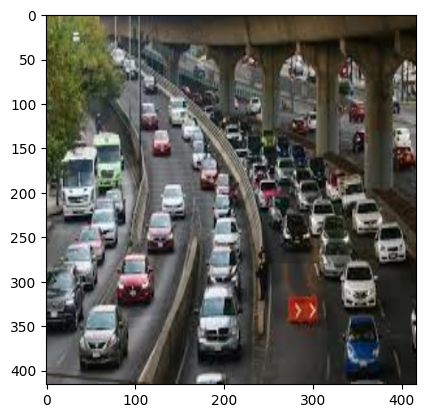

In [ ]:
photo_filename='/content/drive/My Drive/yolo_colab/images/traffic.jpg'
_image, image_w, image_h=load_and_preprocess_image(photo_filename,[IMAGE_WIDTH,IMAGE_HEIGHT])
plt.imshow(_image)

In [ ]:
image = expand_dims(_image, 0)
yhat = model.predict(image)
print([a.shape for a in yhat])

1/1 [==============================] - 0s 26ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


## Process output matrix

In [ ]:
# This cell is based on https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
class BoundBox:
	'''
	Objects of boxes. (xmin,ymin) represents the upleft coordinate of the box while (xmax,ymax) means downright one.
	'''
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			# if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

for i in range(len(boxes)):
	x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
	y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
	boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
	boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
	boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
	boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
len(boxes)

10647

## Boxes Filters

From the sections above, it is clear to see that there are over ten thousands of boxes detected. This next step is to filter the boxes with very low confidence by using threshold.

In [ ]:
def box_filter(boxes,labels,threshold_socre):
	valid_boxes=[]
	valid_labels=[]
	valid_scores=[]
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > threshold_socre:
				valid_boxes.append(box)
				valid_labels.append(labels[i])
				valid_scores.append(box.classes[i])

	return (valid_boxes,valid_labels,valid_scores)

In [ ]:
valid_data= box_filter(boxes, labels, threshold_socre=0.6)

## Draw all the boxes

In [ ]:
def draw_boxes(filename, valid_data):

	data = pyplot.imread(filename)
	pyplot.imshow(data)
	ax = pyplot.gca()
	for i in range(len(valid_data[0])):
		box = valid_data[0][i]
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		ax.add_patch(rect)
		print(valid_data[1][i], valid_data[2][i])
		label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
		pyplot.text(x1, y1, label, color='white')
	pyplot.show()

truck 0.89535695
truck 0.8465529
truck 0.83055246
truck 0.7932267
truck 0.8900961
truck 0.7640679
car 0.6353008
car 0.89608866
car 0.86085564
car 0.91446626
car 0.78703517
car 0.63299114
car 0.923029
car 0.9895182
car 0.8840053
car 0.66122276
car 0.94002706
car 0.7200123
car 0.6914767
car 0.8929293
car 0.79785043
car 0.93367594
car 0.83738977
car 0.9379065
car 0.6318027
car 0.9550747
car 0.6076544
car 0.84849644
car 0.8956461
car 0.81838995
car 0.98169875
car 0.9828768
car 0.9733559
car 0.9765451
car 0.92271316
car 0.9484063
car 0.82919514
car 0.8495967
car 0.9281606
car 0.97344744
car 0.9717062
car 0.9404475
car 0.9479981
car 0.93758357
car 0.75385255
car 0.7687013
car 0.74541366
car 0.7375362
car 0.9697833
car 0.93192065
car 0.98890096
car 0.96416545
car 0.9942155
car 0.9823161
car 0.6380341
car 0.8105161
car 0.6528539
car 0.6892791
car 0.95770425
car 0.89623517
car 0.90818995
car 0.8194035
car 0.9476586
car 0.69962084
car 0.6814761
car 0.8925702
car 0.6290864
car 0.8001288
car 0.737

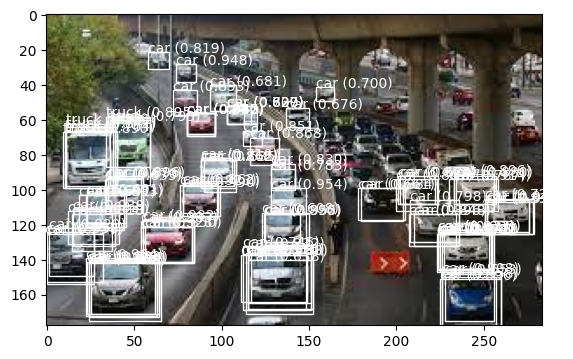

In [ ]:
draw_boxes(photo_filename,valid_data)

## Non-max Seppression, NMS

In [ ]:
def encoder_dic(valid_data):
  data_dic={}
  (valid_boxes,valid_labels,valid_scores)=valid_data
  for box, label,score in zip(valid_boxes,valid_labels,valid_scores):
    if label not in data_dic:
      data_dic[label]=[[score,box,'kept']]
    else:
      data_dic[label].append([score,box,'kept'])

  return data_dic
dic=encoder_dic(valid_data)

In [ ]:
def decode_box_coor(box):
  return (box.xmin, box.ymin,box.xmax, box.ymax )

def iou(box1, box2):
  (box1_x1, box1_y1, box1_x2, box1_y2) = decode_box_coor(box1)
  (box2_x1, box2_y1, box2_x2, box2_y2) = decode_box_coor(box2)

  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-inter_area

  iou = inter_area/union_area

  return iou

def do_nms(data_dic, nms_thresh):
  final_boxes,final_scores,final_labels=list(),list(),list()
  for label in data_dic:
    scores_boxes=sorted(data_dic[label],reverse=True)
    for i in range(len(scores_boxes)):
      if scores_boxes[i][2]=='removed': continue
      for j in range(i+1,len(scores_boxes)):
        if iou(scores_boxes[i][1],scores_boxes[j][1]) >= nms_thresh:
          scores_boxes[j][2]="removed"

    for e in scores_boxes:
      print(label+' '+str(e[0]) + " status: "+ e[2])
      if e[2]=='kept':
        final_boxes.append(e[1])
        final_labels.append(label)
        final_scores.append(e[0])


  return (final_boxes,final_labels,final_scores)

In [ ]:
final_data=do_nms(dic, 0.7)

truck 0.89535695 status: kept
truck 0.8900961 status: kept
truck 0.8465529 status: removed
truck 0.83055246 status: removed
truck 0.7932267 status: kept
truck 0.7640679 status: removed
car 0.9942155 status: kept
car 0.9895182 status: kept
car 0.98890096 status: removed
car 0.9828768 status: kept
car 0.9823161 status: removed
car 0.98169875 status: removed
car 0.9765451 status: kept
car 0.97344744 status: removed
car 0.9733559 status: removed
car 0.9717062 status: removed
car 0.9704221 status: kept
car 0.9697833 status: kept
car 0.96416545 status: removed
car 0.95770425 status: kept
car 0.9550747 status: kept
car 0.95360523 status: kept
car 0.9515663 status: removed
car 0.9484063 status: removed
car 0.9479981 status: removed
car 0.9476586 status: kept
car 0.9447674 status: removed
car 0.9404475 status: removed
car 0.94002706 status: kept
car 0.9379065 status: kept
car 0.93758357 status: kept
car 0.93367594 status: removed
car 0.93192065 status: removed
car 0.9281606 status: removed
car 

truck 0.89535695
truck 0.8900961
truck 0.7932267
car 0.9942155
car 0.9895182
car 0.9828768
car 0.9765451
car 0.9704221
car 0.9697833
car 0.95770425
car 0.9550747
car 0.95360523
car 0.9476586
car 0.94002706
car 0.9379065
car 0.93758357
car 0.91446626
car 0.8963884
car 0.89608866
car 0.8956461
car 0.8929293
car 0.8925702
car 0.8840053
car 0.868245
car 0.86594534
car 0.86085564
car 0.85687655
car 0.8508459
car 0.8295947
car 0.8194035
car 0.81838995
car 0.8001288
car 0.79785043
car 0.74541366
car 0.69962084
car 0.6814761
car 0.67561007


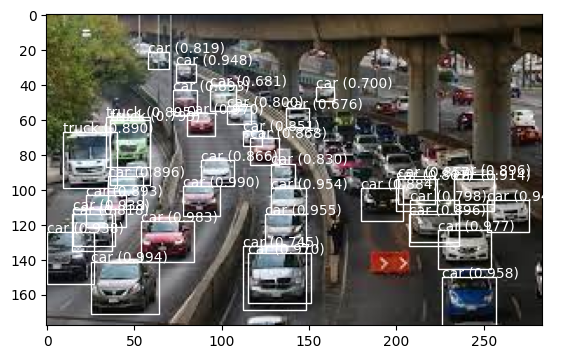

In [ ]:
draw_boxes(photo_filename,final_data)

### Use Keras "non_max_suppression"

In [ ]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):

    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(scores=scores,boxes=boxes,max_output_size=max_boxes,iou_threshold=iou_threshold)

    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

## Other Results

In [ ]:
def showresults(path):
  _image,width,height=load_and_preprocess_image(path,[IMAGE_WIDTH,IMAGE_HEIGHT])
  image = expand_dims(_image, 0)
  yhat = model.predict(image)
  boxes = list()
  for i in range(len(yhat)):
	  boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)
  for i in range(len(boxes)):
    x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
    y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
  valid_data= box_filter(boxes, labels, threshold_socre=0.6)
  dic=encoder_dic(valid_data)
  final_data=do_nms(dic, 0.7)
  draw_boxes(path,final_data)

1/1 [==============================] - 0s 27ms/step
truck 0.89535695 status: kept
truck 0.8900961 status: kept
truck 0.8465529 status: removed
truck 0.83055246 status: removed
truck 0.7932267 status: kept
truck 0.7640679 status: removed
car 0.9942155 status: kept
car 0.9895182 status: kept
car 0.98890096 status: removed
car 0.9828768 status: kept
car 0.9823161 status: removed
car 0.98169875 status: removed
car 0.9765451 status: kept
car 0.97344744 status: removed
car 0.9733559 status: removed
car 0.9717062 status: removed
car 0.9704221 status: kept
car 0.9697833 status: kept
car 0.96416545 status: removed
car 0.95770425 status: kept
car 0.9550747 status: kept
car 0.95360523 status: kept
car 0.9515663 status: removed
car 0.9484063 status: removed
car 0.9479981 status: removed
car 0.9476586 status: kept
car 0.9447674 status: removed
car 0.9404475 status: removed
car 0.94002706 status: kept
car 0.9379065 status: kept
car 0.93758357 status: kept
car 0.93367594 status: removed
car 0.9319206

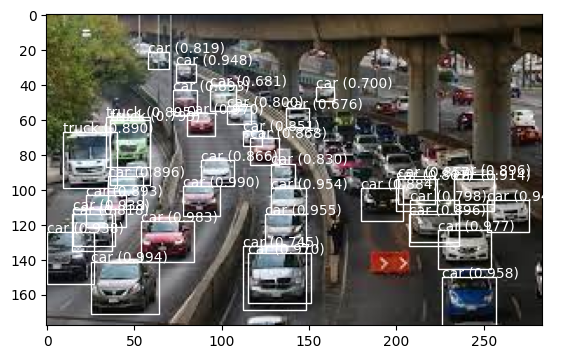

In [ ]:
#showresults('/content/drive/My Drive/DPprojects/Object Detection - Yolo/images/zebra.jpg')
showresults('/content/drive/My Drive/yolo_colab/images/traffic.jpg')

horse 0.9981356 status: kept
horse 0.992822 status: removed
horse 0.9498803 status: removed
horse 0.8879715 status: removed
horse 0.7980072 status: removed
horse 0.7887686 status: removed
horse 0.63090116 status: removed
horse 0.9981356


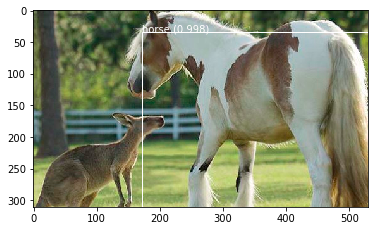

In [ ]:
showresults('/content/drive/My Drive/DPprojects/Object Detection - Yolo/images/kangaroo.png')